In [45]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

In [47]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

try:
    russian_stopwords = stopwords.words('russian')
except:
    nltk.download('stopwords')
    russian_stopwords = stopwords.words('russian')

In [48]:
train_bodies = pd.read_csv('./data/train_bodies.csv')
test_bodies = pd.read_csv('./data/test_bodies.csv')

train_stances = pd.read_csv('./data/train_stances.csv')
test_stances = pd.read_csv('./data/test_stances_unlebeledb.csv') 

# Проведем предобработку данных

## Объединим данные

In [49]:
train_data = train_stances.merge(train_bodies, on='Body ID', how='left')
test_data = test_stances.merge(test_bodies, on='Body ID', how='left')

## Проведем предобработку русского языка

In [50]:
def preprocess_text(text):
    if not isinstance(text, str) or len(text) == 0:
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in russian_stopwords and len(word) > 2]
    
    return ' '.join(words)

## Обработка заголовков и текстов

In [51]:
train_data['headline_clean'] = train_data['Headline'].apply(preprocess_text)
train_data['body_clean'] = train_data['articleBody'].apply(preprocess_text)

test_data['headline_clean'] = test_data['Headline'].apply(preprocess_text)
test_data['body_clean'] = test_data['articleBody'].apply(preprocess_text)


## Создадим комбинированные признаки (заголовок + начало текста)

In [53]:
def combine_features(row, max_body_words=100):
    headline = row['headline_clean']
    body_words = row['body_clean'].split()[:max_body_words]
    body = ' '.join(body_words)
    return f"{headline} {body}"

In [55]:
train_data['combined_text'] = train_data.apply(combine_features, axis=1)
test_data['combined_text'] = test_data.apply(combine_features, axis=1)

In [56]:
train_data = train_data[train_data['combined_text'].str.len() > 10].reset_index(drop=True)
test_data = test_data[test_data['combined_text'].str.len() > 10].reset_index(drop=True)

In [57]:
train_data['text_length'] = train_data['combined_text'].str.split().str.len()
print(f"\nСтатистика длины комбинированных текстов (в словах):")
print(train_data['text_length'].describe())


Статистика длины комбинированных текстов (в словах):
count    4408.000000
mean      100.833711
std        15.256562
min         9.000000
25%       101.000000
50%       107.000000
75%       109.000000
max       125.000000
Name: text_length, dtype: float64


## Подготовим целевую переменную
---
где:
* Реальная новость - 1
* Фейк - 0

In [58]:
label_mapping = {'agree': 1, 'disagree': 0}

train_data['label'] = train_data['Stance'].map(label_mapping)

# Разделим данные

In [59]:
X = train_data['combined_text']
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
print(f"\nРаспределение классов в train:")
print(y_train.value_counts())
print(f"\nРаспределение классов в validation:")
print(y_val.value_counts())


Распределение классов в train:
label
0    1777
1    1749
Name: count, dtype: int64

Распределение классов в validation:
label
0    444
1    438
Name: count, dtype: int64


# Векторизация

In [61]:
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),  
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f"✓ Размерность векторов: {X_train_vec.shape[1]} признаков")
print(f"✓ Разреженность: {(1 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])) * 100:.2f}%")

✓ Размерность векторов: 8000 признаков
✓ Разреженность: 99.22%


# Обучим 3 модели и в последствии выберем лучшую
---
* Logistic Regression
* Naive Bayes
* Random Forest

In [62]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=1.0,
        random_state=42,
        class_weight='balanced'  # Для несбалансированных классов
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=30,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
}

In [63]:
results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    print("  Обучение модели...")
    model.fit(X_train_vec, y_train)
    
    y_train_pred = model.predict(X_train_vec)
    y_val_pred = model.predict(X_val_vec)
    
    # Метрики
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val Accuracy:   {val_acc:.4f}")
    print(f"  Val F1-Score:   {val_f1:.4f}")
    
    print(f"\n  Classification Report (Validation):")
    print(classification_report(y_val, y_val_pred,
                                target_names=['Фейк (disagree)', 'Реальная (agree)'],
                                digits=4))
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'predictions': y_val_pred
    }


--- Logistic Regression ---
  Обучение модели...
  Train Accuracy: 0.9850
  Val Accuracy:   0.9524
  Val F1-Score:   0.9524

  Classification Report (Validation):
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9408    0.9662    0.9533       444
Реальная (agree)     0.9648    0.9384    0.9514       438

        accuracy                         0.9524       882
       macro avg     0.9528    0.9523    0.9524       882
    weighted avg     0.9527    0.9524    0.9524       882


--- Naive Bayes ---
  Обучение модели...
  Train Accuracy: 0.9648
  Val Accuracy:   0.9376
  Val F1-Score:   0.9376

  Classification Report (Validation):
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9237    0.9550    0.9391       444
Реальная (agree)     0.9527    0.9201    0.9361       438

        accuracy                         0.9376       882
       macro avg     0.9382    0.9375    0.9376       882
    weighted avg     0.9381    0.9376

# Проверим на метриках

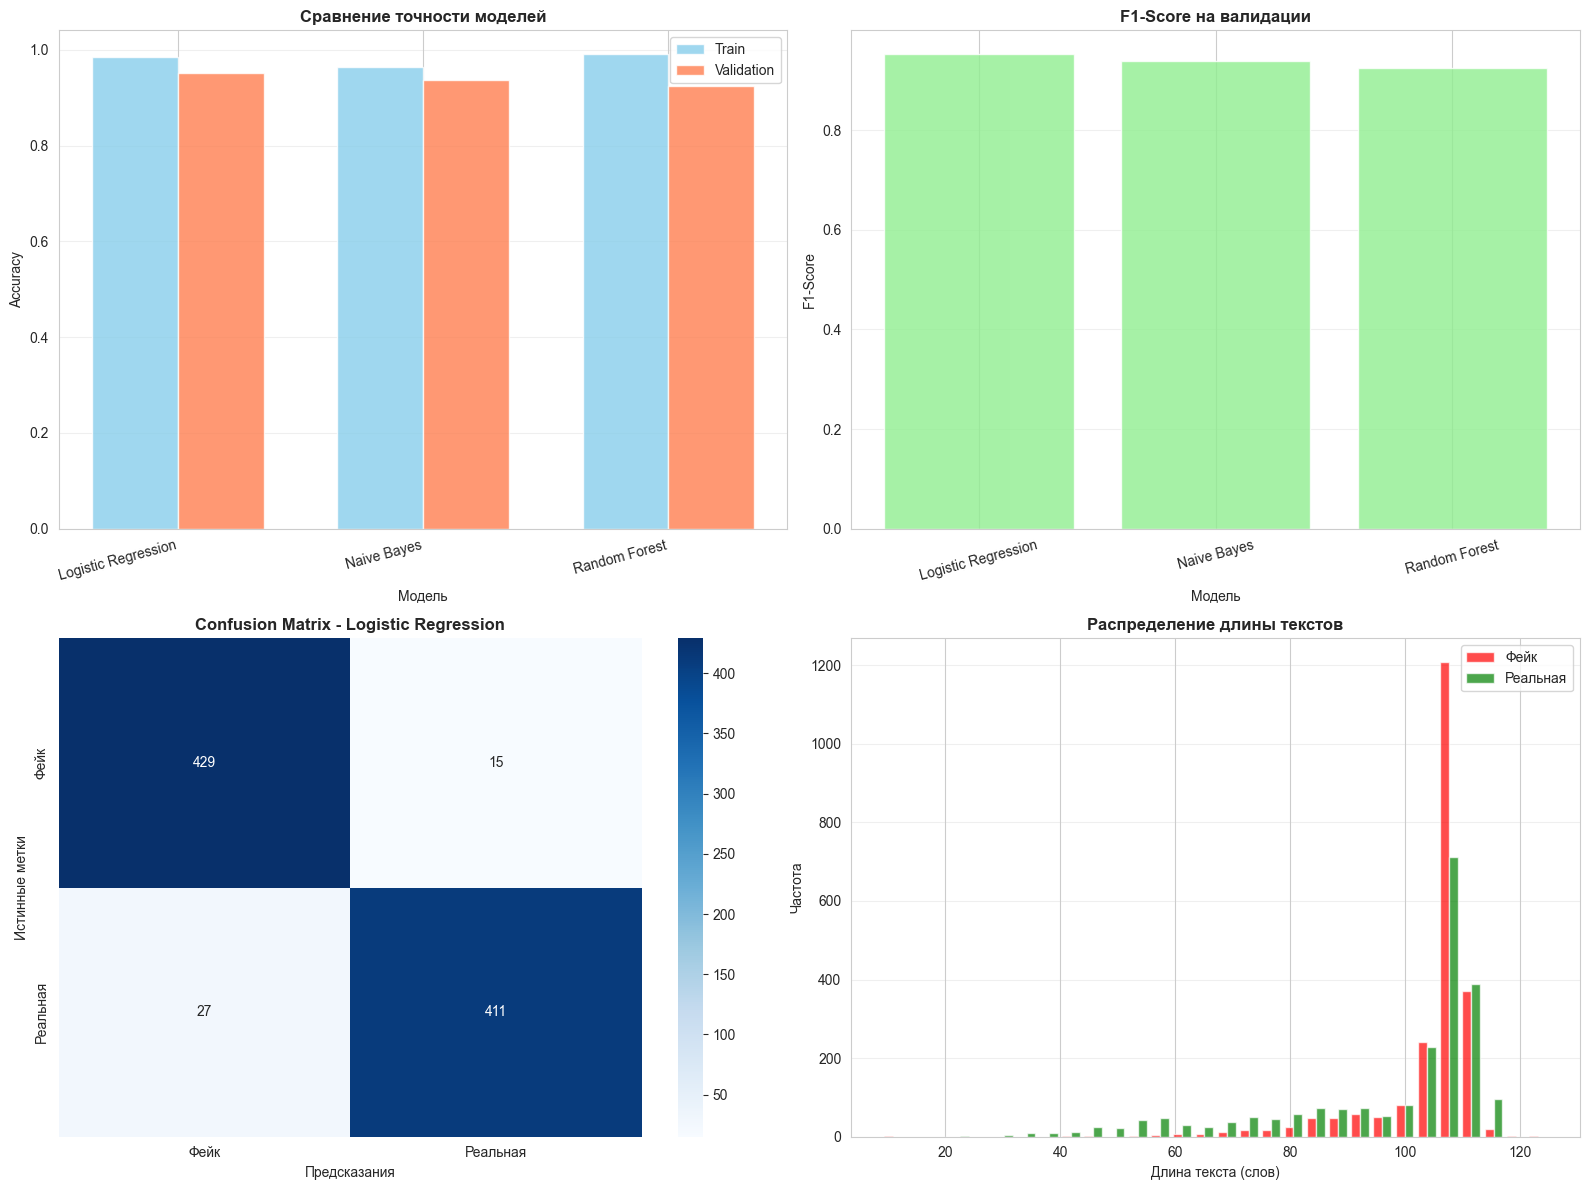

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Accuracy
model_names = list(results.keys())
train_accs = [results[name]['train_acc'] for name in model_names]
val_accs = [results[name]['val_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 0].bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='coral')
axes[0, 0].set_xlabel('Модель')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Сравнение точности моделей', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# График 2: F1-Score
val_f1s = [results[name]['val_f1'] for name in model_names]

axes[0, 1].bar(model_names, val_f1s, alpha=0.8, color='lightgreen')
axes[0, 1].set_xlabel('Модель')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score на валидации', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(axis='y', alpha=0.3)

# График 3: Confusion Matrix
best_model_name = max(results, key=lambda x: results[x]['val_acc'])
best_predictions = results[best_model_name]['predictions']

cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Фейк', 'Реальная'],
            yticklabels=['Фейк', 'Реальная'])
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[1, 0].set_ylabel('Истинные метки')
axes[1, 0].set_xlabel('Предсказания')

# График 4: Распределение длины текстов
axes[1, 1].hist([train_data[train_data['label']==0]['text_length'],
                 train_data[train_data['label']==1]['text_length']],
                bins=30, label=['Фейк', 'Реальная'], alpha=0.7, color=['red', 'green'])
axes[1, 1].set_xlabel('Длина текста (слов)')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].set_title('Распределение длины текстов', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/fake_news_analysis.png', dpi=300)

# Сохраним модели

In [68]:
best_model = results[best_model_name]['model']
best_acc = results[best_model_name]['val_acc']
best_f1 = results[best_model_name]['val_f1']

print(f"Лучшая модель: {best_model_name}")
print(f"Validation Accuracy: {best_acc:.4f}")
print(f"Validation F1-Score: {best_f1:.4f}")

# Сохранение
with open('./models/fake_news_detector.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('./models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('./models/label_mapping.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)

Лучшая модель: Logistic Regression
Validation Accuracy: 0.9524
Validation F1-Score: 0.9524


In [69]:
import json
from pathlib import Path

metrics = {
    "best_model_name": best_model_name,
    "val_accuracy": float(best_acc),
    "val_f1": float(best_f1)
}
Path("results/metrics").mkdir(parents=True, exist_ok=True)
with open("results/metrics/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)
